In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set(color_codes=True)
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
XAVIER= tf.contrib.layers.xavier_initializer(uniform = True)
CONST = tf.constant_initializer(0.0)
NORMAL = tf.random_normal_initializer(mean = 0.0, stddev = 0.5)

def images_print(images, save_name=None):
    batch = len(images)
    row = int(np.sqrt(batch))
    if row*row == batch:
        images_r = np.reshape(images, [row,row, 28,28])
        imap = np.transpose(images_r, [0,2,1,3])
        imap_r = np.reshape(imap, [28*row, 28*row])
        fig = plt.figure(figsize=(5, 5))
        plt.imshow(imap_r, cmap='gray')
        plt.axis('off')
        if save_name is None:
            plt.show()        
        else:
            plt.savefig(save_name)
            plt.close(fig)
        return

def linear(input, output_dim, scope=None):
    '''
    operation :
        input :
            matrixes(a*b) dim = 2
        input.get_shape() => (a, b)
        input.get_shape()[1] => b
        w => b*output_dim
        tf.matmul(input, w ) => a * output_dim
        b= > output_dim
    return :
        matrixes(a*output_dim) 
    '''
    
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=XAVIER)
        b = tf.get_variable('b', [output_dim], initializer=NORMAL)
        return tf.matmul(input, w) + b

def get_shape(tensor):
    return tensor.get_shape().as_list()

def print_var(string):
    '''
        print var_name and var_shape in collection named string
    '''
    print("\n".join(["{} : {}".format(v.name, get_shape(v)) for v in tf.get_collection(string)]))

In [3]:
mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
train = {}
test = {}
val = {}
train['input'] = mnist.train.images
train['output'] = mnist.train.labels
test['input'] = mnist.test.images
test['output'] = mnist.test.labels
val['input'] = mnist.validation.images
val['output'] = mnist.validation.labels

In [5]:
batch_size = 100
batch_num = 550
epoch = 20
rnn_size = 32
output_size = input_size = 28
nsequences = 27

In [6]:
x = tf.placeholder(tf.float32, shape= [batch_size, nsequences, input_size])
y = tf.placeholder(tf.float32, shape= [batch_size, nsequences, output_size])

x_t = tf.transpose(x, [1,0,2])
x_r = tf.reshape(x_t, [-1, input_size])
x_split = tf.split(x_r, nsequences, axis = 0)

with tf.variable_scope("rnn") as scope:
    rnn_cell = tf.contrib.rnn.BasicLSTMCell(rnn_size)
    wrapped_cell = tf.contrib.rnn.OutputProjectionWrapper(rnn_cell, output_size)
    outputs, states = tf.contrib.rnn.static_rnn(wrapped_cell, x_split, dtype=tf.float32) 

outputs_stack = tf.stack(outputs)
outputs_t = tf.transpose(tf.sigmoid(outputs_stack), [1, 0 , 2])
square_error = tf.reduce_mean(tf.square(outputs_t-y))
run_train = tf.train.AdamOptimizer().minimize(square_error)

In [7]:
print_var("trainable_variables")

rnn/rnn/output_projection_wrapper/basic_lstm_cell/kernel:0 : [60, 128]
rnn/rnn/output_projection_wrapper/basic_lstm_cell/bias:0 : [128]
rnn/rnn/output_projection_wrapper/kernel:0 : [32, 28]
rnn/rnn/output_projection_wrapper/bias:0 : [28]


# Determine whether restore or not

In [8]:
restore = False

In [ ]:
sess = tf.Session()
if restore:
    saver = tf.train.Saver()
    saver.restore(sess, './save2/model')
else :
    sess.run(tf.global_variables_initializer())
    for e in range(epoch):
        index = np.arange(len(train['input']))
        np.random.shuffle(index)
        trX = train['input'][index]
        epoch_loss = 0 
        for batch in range(batch_num):
            train_batch = trX[batch*batch_size:(batch+1)*batch_size]
            train_batch_r = np.reshape(train_batch, [batch_size, 28, 28])
            input_batch = np.transpose(np.transpose(train_batch_r, [1, 0, 2])[:-1], [1,0,2])
            output_batch = np.transpose(np.transpose(train_batch_r, [1, 0, 2])[1:], [1,0,2])
            train_feed_dict = {x : input_batch, y : output_batch}
            _, cost = sess.run([run_train, square_error], feed_dict=train_feed_dict)
            epoch_loss += cost
        print('Epoch({}/{}) cost = {}'.format(e+1, epoch, epoch_loss))
    saver = tf.train.Saver()
    saver.save(sess, './save2/model')

Epoch(1/20) cost = 46.95606875047088


In [13]:
def images_generator(images, keep_num = 14):
    image_r = np.reshape(images, [batch_size, 28, 28])
    image_restore = np.zeros((batch_size, 28, 28))
    for i in range(batch_size):
        for j in range(keep_num):
            for k in range(28):
                image_restore[i][j][k] = image_r[i][j][k] 

    for j in range(keep_num, 28):
        restored = sess.run(outputs_t, feed_dict ={x : image_restore[:,:-1,:]})
        for i in range(batch_size):
            for k in range(28):
                image_restore[i][j][k] = restored[i][j-1][k]
    return image_restore

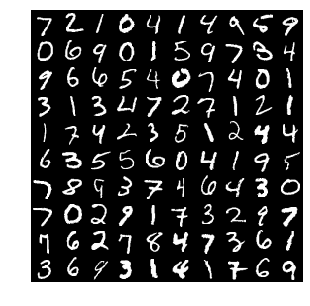

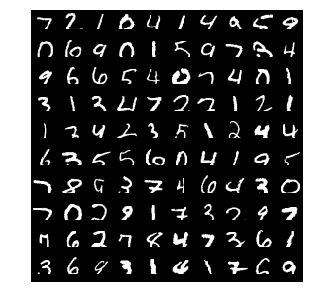

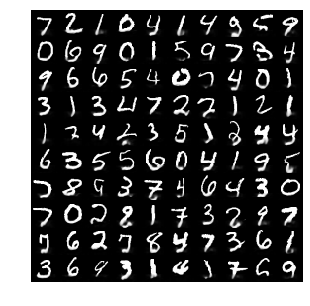

In [15]:
start = 0
image_sample = np.reshape(test['input'][start:start+batch_size], [batch_size, 28, 28])
keep_row = 20
image_clip = np.zeros((batch_size, 28, 28))
for i in range(batch_size):
    for j in range(keep_row):
        for k in range(28):
            image_clip[i][j][k] = image_sample[i][j][k]
image_fake = images_generator(image_sample, keep_row)
images_print(image_sample)
images_print(image_clip)
images_print(image_fake)